# Customer Churn Prediction

In this notebook, we are predicting whether a customer of H&M is going to [churn](https://relbench.stanford.edu/datasets/rel-hm/#user-churn). We built a relational data model comprising customers, transactions, and articles, and combined them in getML. We then trained an XGBoostClassifier on the aggregated features that getML produced through its feature-learning process (FastProp).

Below, we walk through how we (1) evaluate the pipeline performance, 
(2) visualize and interpret feature and column importances.

We build this prediction model on top of the H&M data set out of the [Relational Deep Learning Benchmark (RelBench)](https://relbench.stanford.edu/) which coonsists out of 3 Tables, 37 columns and in total ~33 million rows.

In [1]:
# -------------------------------------------------------------------------------
# # Step 1: Installing Dependencies (Optional)
# -------------------------------------------------------------------------------
# We assume you already have all necessary dependencies installed.
# Otherwise, uncomment the line above to install them.

# !pip install getml pyarrow relbench


In [2]:
# -------------------------------------------------------------------------------
# # Step 2: Start getML & Loading the "H&M user-churn" Data
# -------------------------------------------------------------------------------
# We use relbench.datasets and relbench.tasks to fetch:
#  - dataset: "rel-hm"
#  - task: "user-churn"

import getml

from relbench.datasets import get_dataset
from relbench.tasks import get_task

# Download the dataset and task
dataset = get_dataset("rel-hm", download=True)
task = get_task("rel-hm", "user-churn", download=True)

# If the engine is already running, let's shut it down to start fresh:
if getml.engine.is_alive():
    getml.engine.shutdown()

# Force textual output in logs
getml.utilities.progress.FORCE_TEXTUAL_OUTPUT = True
getml.engine.launch()

# Set the project name in getML so we can keep track of all objects
getml.set_project("hm-churn")


Shutting down the getML Engine...

Done.

Launching ./getML --allow-push-notifications=true --allow-remote-ips=false --home-directory=/home/jupyter/.getML --in-memory=true --install=false --launch-browser=true --log=false --project-directory=/home/jupyter/.getML/projects in /opt/conda/lib/python3.10/site-packages/getml/.getML/getml-community-1.5.0-amd64-linux...
Launched the getML Engine. The log output will be stored in /home/jupyter/.getML/logs/getml_20241228175105.log
  Loading pipelines... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:005m 80% • 00:01


Connected to project 'hm-churn'.

In [3]:
# -------------------------------------------------------------------------------
# # Step 3: Loading Data, Inspecting, and Setting Roles (Data Annotation)
# -------------------------------------------------------------------------------
# The h&m user-churn dataset includes multiple parquet files:
#   customer.parquet, article.parquet, transactions.parquet,
#   plus train/test/val splits for the population with "churn" target.
#
# Next, we will:
#   - Load each table from disk,
#   - Display it to understand its columns,
#   - Assign the appropriate roles (join_key, time_stamp, numerical, categorical, etc.).
#
# Roles are essential so getML knows how to link tables, handle time constraints,
# and decide how to encode each column (particularly crucial for large data).
#
# ## 1) Customer table
#    - We first load it to see which columns exist,
#    - Then we assign roles: join_key = "customer_id", numerical = "age",
#      categorical for membership flags, etc.

customer = getml.data.DataFrame.from_parquet(
    f"{dataset.cache_dir}/db/customer.parquet", 
    "customer"
)

# Let's inspect the table before we assign the respective roles
customer

name,customer_id,FN,Active,age,club_member_status,fashion_news_frequency,postal_code
role,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string
0,0,nan,nan,49,ACTIVE,NONE,52043ee2162cf5aa7ee79974281641c6...
1,1,nan,nan,25,ACTIVE,NONE,2973abc54daa8a5f8ccfe9362140c632...
2,2,nan,nan,24,ACTIVE,NONE,64f17e6a330a85798e4998f62d0930d1...
3,3,nan,nan,54,ACTIVE,NONE,5d36574f52495e81f019b680c843c443...
4,4,1,1,52,ACTIVE,Regularly,25fa5ddee9aac01b35208d01736e5794...
,...,...,...,...,...,...,...
1371975,1371975,nan,nan,24,ACTIVE,NONE,7aa399f7e669990daba2d92c577b5223...
1371976,1371976,nan,nan,21,ACTIVE,NONE,3f47f1279beb72215f4de557d950e0bf...
1371977,1371977,1,1,21,ACTIVE,Regularly,4563fc79215672cd6a863f2b4bf56b8f...


In [4]:
# Based on the content of each colum we will now assign appropriate roles.

customer.set_role("customer_id", getml.data.roles.join_key)

customer.set_role(["age"], getml.data.roles.numerical)

customer.set_role(
    [
        "FN", 
        "Active", 
        "club_member_status", 
        "fashion_news_frequency",
        "postal_code"
    ], 
    getml.data.roles.categorical
)

In [5]:
# ## 2) Article table
#    - Inspect columns,
#    - Then assign roles. Many numeric codes are effectively ID categories, 
#      so we set them to 'categorical'.

article = getml.data.DataFrame.from_parquet(
    f"{dataset.cache_dir}/db/article.parquet", 
    "article"
)

# Let's inspect the table before we assign the respective roles
article

name,article_id,product_code,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_group_no,section_no,garment_group_no,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_code,index_name,index_group_name,section_name,garment_group_name,detail_desc
role,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string
0,0,108775,253,1010016,9,4,5,1676,1,16,1002,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,A,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder ...
1,1,108775,253,1010016,10,3,9,1676,1,16,1002,Strap top,Vest top,Garment Upper body,Solid,White,Light,White,Jersey Basic,A,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder ...
2,2,108775,253,1010017,11,1,9,1676,1,16,1002,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Jersey Basic,A,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder ...
3,3,110065,306,1010016,9,4,5,1339,1,61,1017,OP T-shirt (Idro),Bra,Underwear,Solid,Black,Dark,Black,Clean Lingerie,B,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear",Microfibre T-shirt bra with unde...
4,4,110065,306,1010016,10,3,9,1339,1,61,1017,OP T-shirt (Idro),Bra,Underwear,Solid,White,Light,White,Clean Lingerie,B,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear",Microfibre T-shirt bra with unde...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105537,105537,953450,302,1010014,9,4,5,7188,3,26,1021,5pk regular Placement1,Socks,Socks & Tights,Placement print,Black,Dark,Black,Socks Bin,F,Menswear,Menswear,Men Underwear,Socks and Tights,Socks in a fine-knit cotton blen...
105538,105538,953763,253,1010016,9,4,5,1919,1,2,1005,SPORT Malaga tank,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey,A,Ladieswear,Ladieswear,H&M+,Jersey Fancy,Loose-fitting sports vest top in...
105539,105539,956217,265,1010016,9,4,5,1641,1,18,1005,Cartwheel dress,Dress,Garment Full body,Solid,Black,Dark,Black,Jersey,A,Ladieswear,Ladieswear,Womens Trend,Jersey Fancy,"Short, A-line dress in jersey wi..."


In [6]:
# Now load the same table but directly set the roles:

article.set_role("article_id", getml.data.roles.join_key)

article.set_role(
    [
        "product_group_name",
        "department_name",
        "garment_group_name",
        "product_code",
        "product_type_no",
        "graphical_appearance_no",
        "colour_group_code",
        "perceived_colour_value_id",
        "perceived_colour_master_id",
        "department_no",
        "index_group_no",
        "section_no",
        "garment_group_no"
    ],
    getml.data.roles.categorical
)

In [7]:
# ## 3) Transaction table
#    - We'll first show it without roles,
#    - Then reload it with the correct roles for time_stamp, numerical, etc.

transaction = getml.data.DataFrame.from_parquet(
    f"{dataset.cache_dir}/db/transactions.parquet", 
    "transaction"
)

# Let's inspect the table before we assign the respective roles
transaction

name,customer_id,article_id,price,sales_channel_id,t_dat
role,unused_float,unused_float,unused_float,unused_float,unused_string
0,155,51985,0.01015,1,2019-09-07 00:00:00.000000000
1,155,51985,0.01015,1,2019-09-07 00:00:00.000000000
2,155,83127,0.04236,1,2019-09-07 00:00:00.000000000
3,155,6066,0.005068,1,2019-09-07 00:00:00.000000000
4,155,78525,0.03388,1,2019-09-07 00:00:00.000000000
,...,...,...,...,...
15453646,1371691,104961,0.05931,2,2020-09-22 00:00:00.000000000
15453647,1371691,100629,0.04236,2,2020-09-22 00:00:00.000000000
15453648,1371721,104053,0.0432,1,2020-09-22 00:00:00.000000000


In [8]:
# For efficiency reasons we define the roles up front,
# and reload the table from parquet with the final roles asigned:

transaction_roles = getml.data.Roles(
    join_key=["article_id", "customer_id"],
    time_stamp=["t_dat"],
    numerical=["price"],
    categorical=["sales_channel_id"],
)

transaction = getml.data.DataFrame.from_parquet(
    f"{dataset.cache_dir}/db/transactions.parquet", 
    "transaction", 
    transaction_roles
)

In [9]:
# ## 4) Population tables (train, test, val) with the churn target.
#    - We'll briefly inspect "train" first,
#    - Then reload all splits with the correct roles.

print("Population (train) table (inspection only, no roles assigned yet):")
train_tmp = getml.data.DataFrame.from_parquet(
    f"{dataset.cache_dir}/tasks/user-churn/train.parquet", 
    "train_tmp"
)

# Let's inspect the table before we assign the respective roles
train_tmp

Population (train) table (inspection only, no roles assigned yet):


name,customer_id,churn,timestamp
role,unused_float,unused_float,unused_string
0,1255921,0,2020-06-08 00:00:00.000000000
1,1256165,0,2020-06-08 00:00:00.000000000
2,1256239,1,2020-06-08 00:00:00.000000000
3,1256569,1,2020-06-08 00:00:00.000000000
4,1256721,1,2020-06-08 00:00:00.000000000
,...,...,...
3832687,1100160,1,2019-12-09 00:00:00.000000000
3832688,1100373,1,2019-12-09 00:00:00.000000000
3832689,1100716,1,2019-12-09 00:00:00.000000000


In [10]:
# Now set roles:
population_roles = getml.data.Roles(
    join_key=["customer_id"],
    target=["churn"],
    time_stamp=["timestamp"]
)

subsets = ("train", "test", "val")
populations = {}
for subset in subsets:
    populations[subset] = getml.data.DataFrame.from_parquet(
        f"{dataset.cache_dir}/tasks/user-churn/{subset}.parquet", 
        subset, 
        population_roles
    )

# Population train table together with the correct roles residing
# in the getML engine:
populations["train"]

name,timestamp,customer_id,churn
role,time_stamp,join_key,target
unit,time stamp,,
0,2020-06-08,1255921,0
1,2020-06-08,1256165,0
2,2020-06-08,1256239,1
3,2020-06-08,1256569,1
4,2020-06-08,1256721,1
,...,...,...
3832687,2019-12-09,1100160,1
3832688,2019-12-09,1100373,1


In [11]:
# -------------------------------------------------------------------------------
# Step 5: Defining the DataModel (Relationship Blueprint)
# -------------------------------------------------------------------------------
# In getML, a DataModel describes how our tables (population, customer, 
# transaction, article) are related—both structurally and with respect
# to time. It does not physically join the tables at this point. Instead,
# it provides the relational schema that getML’s feature learners will
# later use to build features (in line with Statistical Relational Learning).

# 1) We set the “train” table as our population placeholder.
#    In SRL terms, these are our “target instances”—the rows on which 
#    we want to learn and ultimately predict churn.

dm = getml.data.DataModel(population=populations["train"].to_placeholder())

# 2) We add placeholders for our other tables (customer, transaction, article). 
#    They represent the relational background knowledge from which 
#    getML can construct features for each target instance in the population.

dm.add(getml.data.to_placeholder(customer, transaction, article))

# 3) Specify the relational links:
#   - dm.population -> dm.customer on "customer_id"
#       (many_to_one relationship, analogous to a left join).
#   - dm.population -> dm.transaction on "customer_id"
#       plus time_stamps=("timestamp", "t_dat") to prevent data leakage
#       (we only use transactions that occurred before the population’s timestamp).
#   - dm.transaction -> dm.article on "article_id" (many_to_one relationship).
#
# By annotating these relationships and any time constraints, we’re defining 
# the logical structure that getML’s feature learning algorithms will exploit.

dm.population.join(
    dm.customer, 
    on="customer_id", 
    relationship=getml.data.relationship.many_to_one
)

dm.population.join(
    dm.transaction, 
    on="customer_id", 
    time_stamps=("timestamp", "t_dat")
)

dm.transaction.join(
    dm.article, 
    on="article_id", 
    relationship=getml.data.relationship.many_to_one
)

# 4) When visualized (dm in a notebook), this yields a diagram showing 
#    how the target instances (population) are linked to background tables, 
#    forming the basis for relational feature learning in getML.

dm


,data frames,staging table
0,"train, customer",TRAIN__STAGING_TABLE_1
1,"transaction, article",TRANSACTION__STAGING_TABLE_2


In [12]:
# -------------------------------------------------------------------------------
# # Step 6: Creating a Container and Checking
# -------------------------------------------------------------------------------
# The Container ties together all splits (train/test/val) plus the peripheral 
# tables. getML won't physically copy these millions of rows. The purpose of a
# container is to assigning concrete data to an abstract DataModel with focus on
# ease of use and easy reproducability of previous results.

container = getml.data.Container(**populations)
container.add(customer, transaction, article)

# We'll now define a pipeline referencing this DataModel. 

In [13]:
# -------------------------------------------------------------------------------
# Step 7: Defining and Checking the Pipeline
# -------------------------------------------------------------------------------
# Our pipeline will:
#   - Use the DataModel (dm) to understand table relationships,
#   - Use FastProp for automated feature creation,
#   - Use XGBoostClassifier for prediction,
#   - Optimize via CrossEntropyLoss.

pipe = getml.Pipeline(
    tags=["base_pipeline"],
    data_model=dm,
    feature_learners=[getml.feature_learning.FastProp(num_threads=8)],
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
    predictors=[getml.predictors.XGBoostClassifier(n_jobs=8)],
)

# .check(...) does a static analysis on the pipeline, data model and container 
# to see if everything is consistent (time relationships, roles, table joins, etc.).
# We pass the 'train' subset for verification

pipe.check(container.train)


Checking data model...

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:03--:--
  Checking... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:035m 50% • 00:03


The pipeline check generated 2 issues labeled INFO and 0 issues labeled WARNING.

,type,label,message
0,INFO,MIGHT TAKE LONG,The number of unique entries in column 't3__postal_code' in TRAIN__STAGING_TABLE_1 is 319891. This might take a long time to fit. You should consider setting its role to unused_string or using it for comparison only (you can do the latter by setting a unit that contains 'comparison only').
1,INFO,MIGHT TAKE LONG,The number of unique entries in column 't4__product_code' in TRANSACTION__STAGING_TABLE_2 is 33580. This might take a long time to fit. You should consider setting its role to unused_string or using it for comparison only (you can do the latter by setting a unit that contains 'comparison only').


In [14]:
# Based on the info- and warning-messages, we might decide to mark certain columns unused.
# In this example, we realize that 'product_code' or 'postal_code' are not helpful:
article.set_role("product_code", getml.data.roles.unused_string)
customer.set_role("postal_code", getml.data.roles.unused_string)

# Because roles have changed, we can recreate another container 
# so the pipeline sees the updated roles and avoid any warnings.
container_checked = getml.data.Container(**populations)
container_checked.add(customer, transaction, article)

container_checked


population
    subset   name       rows   type     
0   train    train   3832692   DataFrame
1   test     test      74575   DataFrame
2   val      val       76556   DataFrame

peripheral
    name              rows   type     
0   customer       1371980   DataFrame
1   transaction   15453651   DataFrame
2   article         105542   DataFrame

In [15]:
# -------------------------------------------------------------------------------
# Step 8: Fitting the Pipeline
# -------------------------------------------------------------------------------
# .fit(...) orchestrates generating features, and training the XGBoost model. 
# getML’s memory management means we only materialize data 
# needed at each step instead of copying the entire dataset.

pipe.fit(container_checked.train, check=False)


  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:05--:--
  FastProp: Trying 64 features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:0000:05
  FastProp: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:2500:0100:01
  XGBoost: Training as predictor... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 03:25m • 00:0200:06


Trained pipeline.

Time taken: 0:03:56.492414.



Pipeline(data_model='train',
         feature_learners=['FastProp'],
         feature_selectors=[],
         include_categorical=False,
         loss_function='CrossEntropyLoss',
         peripheral=['article', 'customer', 'transaction'],
         predictors=['XGBoostClassifier'],
         preprocessors=[],
         share_selected_features=0.5,
         tags=['base_pipeline', 'container-5YK0cD'])

In [16]:
# We now evaluate the pipeline on the validation and test sets:

pipe.score(container_checked.val)
pipe.score(container_checked.test)
pipe.scores

# Observing the results in pipe.scores, we find the current pipeline 
# meets our performance needs. Therefore, we will skip further optimizations 
# of the data model, feature learner, or pipeline hyperparameters at this stage.

# As a final step, we will explore feature importances, column importances, 
# and examine the logical structure of our learned features. This helps us 
# understand how the pipeline is deriving its predictions and whether 
# certain aspects of the data are particularly influential.

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:01--:--
  Preprocessing... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:0000:01
  FastProp: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:01 • --:--
  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:01--:--
  Preprocessing... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:0000:01
  FastProp: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:01 • --:--


,date time,set used,target,accuracy,auc,cross entropy
0,2024-12-28 17:55:52,train,churn,0.8243,0.6883,0.4358
1,2024-12-28 17:55:56,val,churn,0.8218,0.7117,0.434
2,2024-12-28 17:56:00,test,churn,0.833,0.7066,0.4209


Total number of features: 64


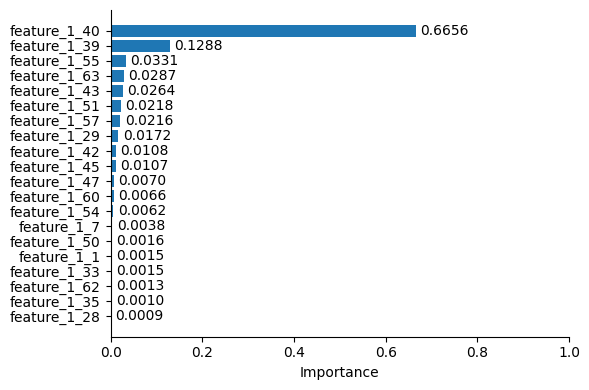

In [17]:
# -------------------------------------------------------------------------------
# Step 9: Feature Importances
# -------------------------------------------------------------------------------
# Since we used XGBoost, we can query each engineered feature's importance. 
# This helps us to understand which features matter for churn.

import matplotlib.pyplot as plt
import pandas as pd

def plot_importances(names, importances, top_n=None):
    """
    Creates a bar chart of importances. 
    Ensures a horizontal layout so we can see longer names easily.
    """
    import pandas as pd
    df = pd.DataFrame({"name": names, "importance": importances}) \
             .sort_values("importance", ascending=False)
    if top_n:
        df = df.head(top_n)
    df = df.iloc[::-1].reset_index(drop=True)
    
    plt.figure(figsize=(6,4))
    plt.barh(df["name"], df["importance"], color="C0")
    plt.xlabel("Importance")
    
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.xlim(0,1)
    
    for i, val in enumerate(df["importance"]):
        plt.text(val + 0.01, i, f"{val:.4f}", va="center")
    
    plt.tight_layout()
    plt.show()

# Retrieve feature importances from the pipeline
feat_names, feat_importances = pipe.features.importances()

print(f"Total number of features: {len(feat_names)}")

# Plot top 20
plot_importances(feat_names, feat_importances, top_n=20)

In [18]:
# If you want to see the underlying SQL logic for the top features:

sql_feature_top1 = pipe.features.to_sql()[feat_names[0]]
print(sql_feature_top1)


DROP TABLE IF EXISTS "FEATURE_1_40";

CREATE TABLE "FEATURE_1_40" AS
SELECT COUNT( DISTINCT t2."t_dat" ) AS "feature_1_40",
       t1.rowid AS rownum
FROM "TRAIN__STAGING_TABLE_1" t1
INNER JOIN "TRANSACTION__STAGING_TABLE_2" t2
ON t1."customer_id" = t2."customer_id"
WHERE t2."t_dat" <= t1."timestamp"
GROUP BY t1.rowid;


In [19]:
# *Interpretation of feature 1: This feature is the count of distinct transaction dates
#  for a given customer prior to the churn-prediction timestamp. 
#  In simpler terms, "How many separate shopping days has the customer had?"

sql_feature_top2 = pipe.features.to_sql()[feat_names[1]]
print(sql_feature_top2)

DROP TABLE IF EXISTS "FEATURE_1_39";

CREATE TABLE "FEATURE_1_39" AS
SELECT LAST( t2."t_dat" ORDER BY t2."t_dat" ) AS "feature_1_39",
       t1.rowid AS rownum
FROM "TRAIN__STAGING_TABLE_1" t1
INNER JOIN "TRANSACTION__STAGING_TABLE_2" t2
ON t1."customer_id" = t2."customer_id"
WHERE t2."t_dat" <= t1."timestamp"
GROUP BY t1.rowid;


In [20]:
# *Interpretation of feature 2: 'TREND' is a getML function that measures how transaction
#  dates cluster over time, indicating momentum or recency in the user's 
#  shopping behavior.

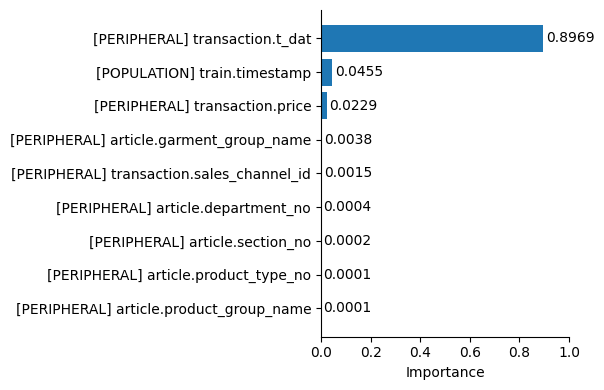

In [21]:
# -------------------------------------------------------------------------------
# Step 10: Column Importances (High-Level)
# -------------------------------------------------------------------------------
# Beyond feature importances, getML can also compute "column importances," 
# showing how each original column (like 'age', 'price', or 'department_name') 
# contributed overall to the final model. 
# This is particularly useful if you want to prune entire columns 
# that have negligible relevance for churn.

col_names, col_importances = pipe.columns.importances()
plot_importances(col_names, col_importances)

# If, for example 'colour_group_code' or 'department_no' are extremely low, 
# we might decide to remove them. 
# This is valuable when dealing with very large data 
# to speed up the pipeline and reduce noise.
